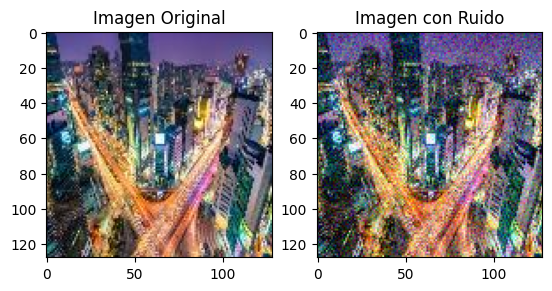

In [7]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Cargar imágenes del conjunto de entrenamiento
city_train_path = "processed_dataset/city/train-city"
forest_train_path = "processed_dataset/forest/train-forest"
img_size = (128, 128)

def load_images(folder):
    images = []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # Normalizar
        images.append(img)
    return np.array(images)

city_train = load_images(city_train_path)
forest_train = load_images(forest_train_path)


# Añadir Ruido Gaussiano
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image


# Añadir Ruido a las Imágene
X_train = np.concatenate([city_train, forest_train])
X_train_noisy = np.array([add_gaussian_noise(img) for img in X_train])


# Ejemplo de Imagen Ruidosa
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_train[0])
axes[0].set_title("Imagen Original")
axes[1].imshow(X_train_noisy[0])
axes[1].set_title("Imagen con Ruido")
plt.show()


In [ ]:
from tensorflow.keras.models import Model
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
import tensorflow.keras.layers as layers

# Inicializar un run de W&B
wandb.init(project="autoencoder-denoising", config={
    "epochs": 50,
    "batch_size": 16,
    "img_size": img_size,
    "architecture": "autoencoder",
    "dataset": "city and forest"
})

# Configuración
config = wandb.config

# Crear el Autoencoder
input_img = layers.Input(shape=(*img_size, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Resumen del Modelo
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Entrenar el modelo
history = autoencoder.fit(X_train_noisy, X_train, epochs=50, batch_size=16, validation_split=0.1, callbacks=[WandbCallback()])
wandb.finish()

# Guardar el modelo
autoencoder.save("models/autoencoder_denoising.h5")

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50


AttributeError: 'Node' object has no attribute 'inbound_layers'

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


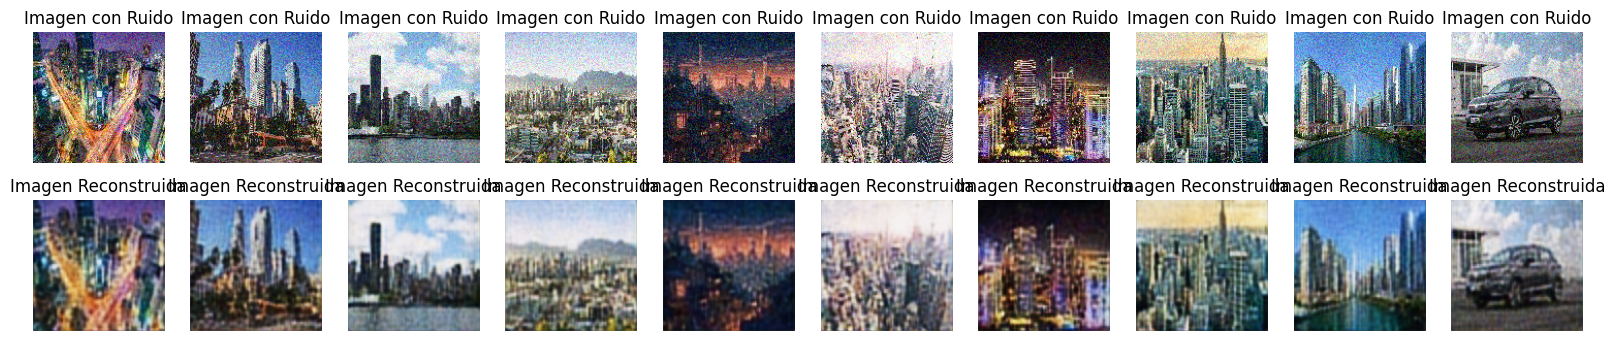

In [18]:
# Comparar Imágenes
decoded_imgs = autoencoder.predict(X_train_noisy)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Imagen Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train_noisy[i])
    plt.title("Imagen con Ruido")
    plt.axis('off')

    # Imagen Reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Imagen Reconstruida")
    plt.axis('off')

plt.show()

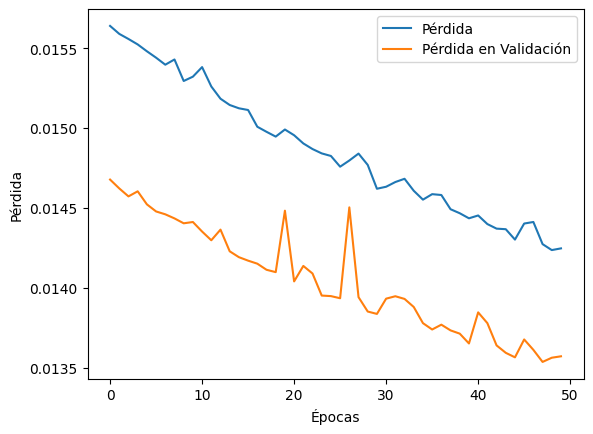

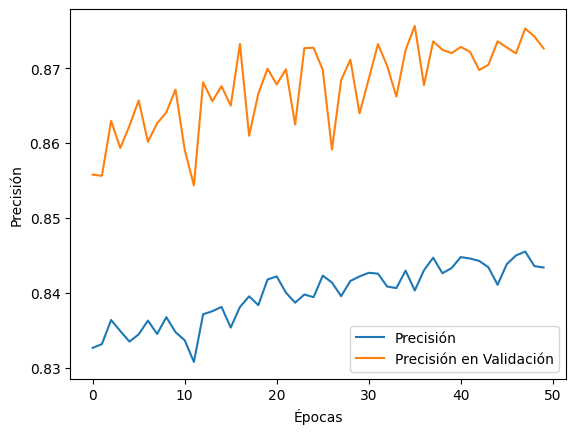

In [16]:
# Graficar la Pérdida y Precisión
plt.plot(history.history['loss'], label='Pérdida')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Precisión')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()